Load package and import data

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import scipy as sp
import pandas as pd
import sklearn as sk
import matplotlib as mpl
import matplotlib.pylab as plt
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")
sns.set_color_codes()

In [2]:
from dask.distributed import Client
import dask.bag as db
import dask.dataframe as dd
import dask

from ast import literal_eval
from collections.abc import MutableMapping
import dask.array as da
import h5py
import os

In [3]:
client = Client(n_workers=4)

In [4]:
client

Client Scheduler: tcp://127.0.0.1:36849 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 20.70 GB


#### Split data into manageable chunks

In [10]:
b = db.read_text("places.clean.json", blocksize="64MiB")
type(b)

dask.bag.core.Bag

#### functions to drop columns and get rid of N/A values

In [13]:
def drop_cols(obj):
    obj.pop('address')
    obj.pop('hours')
    obj.pop('closed')
    obj.pop('name')
    obj.pop('phone')
    return obj
def has_price_and_gps(obj):
    return obj['price'] is not None and obj['gps'] is not None

#### Parallel chunks to be processed

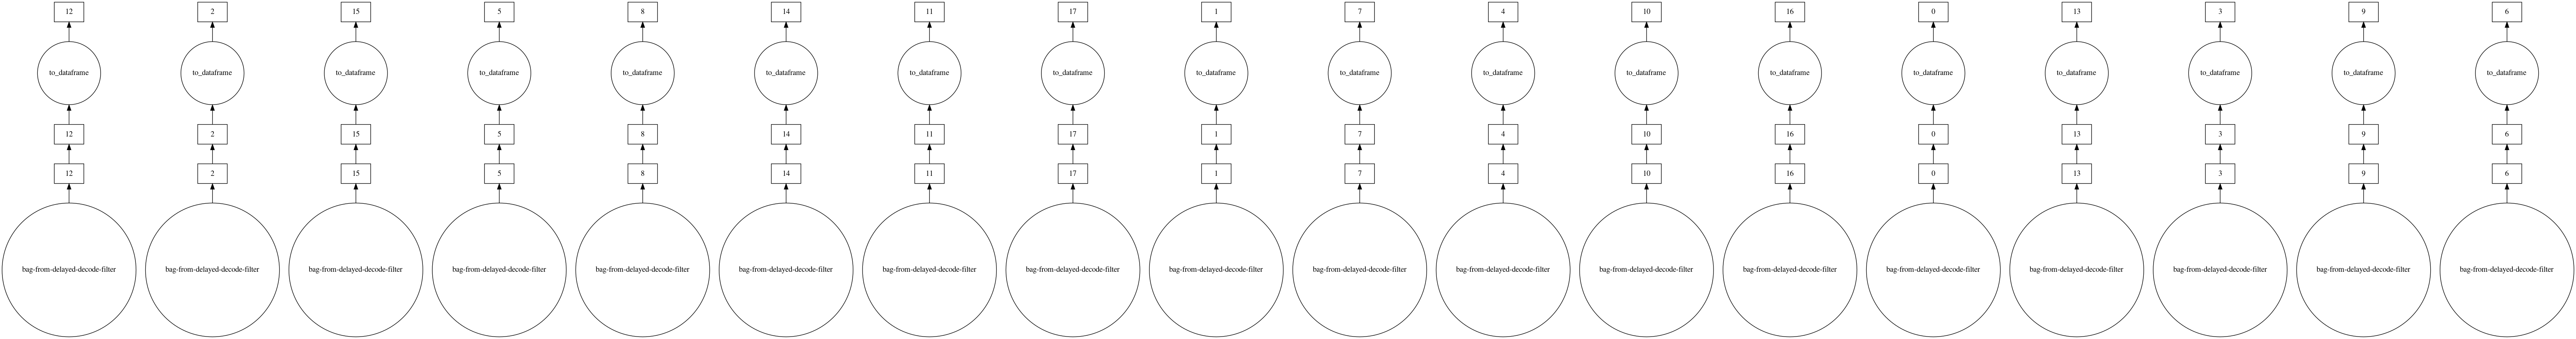

In [14]:
# visualize() requires graphviz module
# conda activate {your env}
# conda install python-graphviz
b.map(literal_eval).filter(has_price_and_gps).map(drop_cols).to_dataframe().visualize()

In [15]:
# about 400k rows and 3 columns (price, gPlusPlaceId, gps)
df = b.map(literal_eval).filter(has_price_and_gps).map(drop_cols).to_dataframe().compute()

In [17]:
df.count()

price           402731
gPlusPlaceId    402731
gps             402731
dtype: int64

In [18]:
df.head()

,price,gPlusPlaceId,gps
0,$$,100327153115986850675,"[43.529494, -96.792244]"
1,$$,118222137795476771294,"[45.535176, -122.862242]"
2,$$,106432060150136868000,"[39.692899, -84.136173]"
3,$$,100184392614713668281,"[35.98598, -83.610598]"
4,$$$,110300304875024740707,"[42.406904, -71.143994]"


In [19]:
prices = df["price"]

In [20]:
prices.value_counts()

$$     188146
$$$    170838
$       15607
££      10139
£££      6175
€€€      4092
         2417
€€       1893
£        1501
€        1003
₩₩₩       209
₱₱₱       180
RRR       141
₱₱         67
₩₩         64
₴₴₴        49
RR         34
฿฿         32
QQQ        24
₴₴         19
₫₫₫        17
₡₡₡        13
₪₪₪        12
฿฿฿        11
₩           8
₪₪          8
₡₡          6
₦₦          4
₸₸          4
₫₫          3
R           3
LLL         2
฿           2
₡           1
₴           1
៛៛៛         1
₱           1
₸           1
៛៛          1
LL          1
QQ          1
Name: price, dtype: int64

In [51]:
gps = df["gps"]
gps_list = gps.to_list()
obj = { 'latitude': [], 'longitude': [] }
for coord in gps_list:
    obj['latitude'].append(coord[0])
    obj['longitude'].append(coord[1])
gpsDF = pd.DataFrame(data=obj)

#### Plot of Global GPS Coordinates

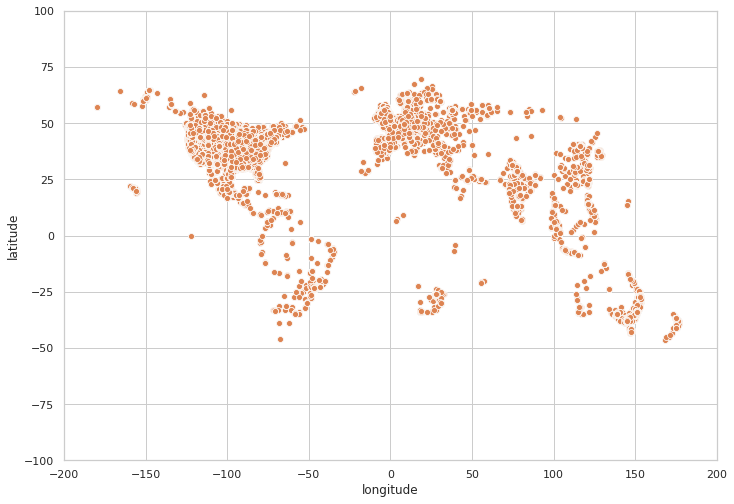

In [45]:
ax = sns.scatterplot(data=gpsDF, x='longitude', y='latitude')
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlim(-200,200)
ax.set_ylim(-100,100)
ax = sns.scatterplot(data=gpsDF, x='longitude', y='latitude', ax=ax)

#### Plot of coordinates in North America

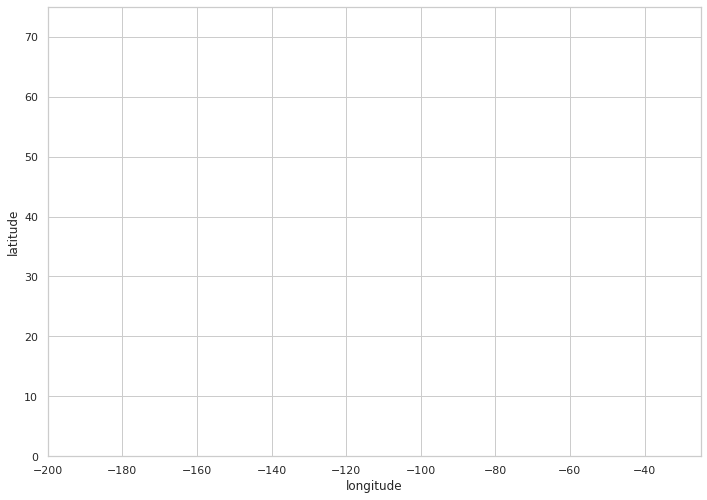

In [56]:
objNA = { 'latitude': [], 'longitude': [] }
for coord in gps_list:
    if coord[0] > -50 and coord[1] > 0:
        objNA['latitude'].append(coord[0])
        objNA['longitude'].append(coord[1])
gpsNA_DF = pd.DataFrame(data=objNA)

ax2 = sns.scatterplot(data=gpsNA_DF, x='longitude', y='latitude')
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_xlim(-200,-25)
ax2.set_ylim(0,75)
sns.scatterplot(data=gpsNA_DF, x='longitude', y='latitude', ax=ax2)